### Import the packages

In [94]:
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import concurrent.futures
pd.set_option("display.max_columns", 100)
import warnings
warnings.filterwarnings(action="ignore")

### Declare some global inputs

In [101]:
lookback_period_start_date = "2022-12-01" # Add the start date of your lookback period
lookback_period_end_date = "2023-01-12" # Add the end date of your lookback period
test_data_filters = [
    # This is the configuration for one test. If you want to add more tests, please specify the parameters in the same way indicated here
    {"entity_id": "PY_CL", "test_name": "CL_20221201_R_B0_O_ElasticityCLRestaurants", "scheme_id": ["634", "635"], "ela_variants": ["Variation1"]},
]
num_bootstrap_samples = 500 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)

### Create the filters list based on "test_data_filters"

In [102]:
filters_list = []
for a in test_data_filters:
    for b in a["scheme_id"]:
        for c in ["Control"] + a["ela_variants"]:
            filters_list.append(" | ".join([a["entity_id"], a["test_name"], b, c]))

# Display the list. Some of the combinations won't return any data and that's fine. It is easier to create all combinations than let the user define them explicitly
filters_list

['PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 634 | Control',
 'PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 634 | Variation1',
 'PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 635 | Control',
 'PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 635 | Variation1']

### Instantiate the BQ client

In [75]:
client = bigquery.Client(project="logistics-customer-staging")
bqstorage_client = bigquery_storage.BigQueryReadClient()

### Orders query

In [104]:
test_query = """
    WITH load_scheme_data AS (
        SELECT 
            entity_id,
            scheme_id,
            scheme_active_from,
            IFNULL(scheme_active_to, CURRENT_TIMESTAMP()) AS scheme_active_to,
            scheme_component_configs.travel_time_config
        FROM `fulfillment-dwh-production.cl.pricing_configuration_versions`
    ),
    
    -- Load order data and join PM data
    dps_order_raw as (
    SELECT
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,
        a.order_placed_at,

        -- Location of order
        ent.segment AS region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
        CASE WHEN ent.segment != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
        a.joker_vendor_fee_local,
        COALESCE(a.service_fee_local, 0) AS service_fee_local,
        a.mov_customer_fee_local AS sof_local,
        a.delivery_costs_local,
        CASE
            WHEN ent.segment IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                pd.delivery_fee_local, 
                -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
            )
            -- If the order comes from a non-Pandora country, use delivery_fee_local
            WHEN ent.segment NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
        END AS actual_df_paid_by_customer,
        a.gfv_local,
        a.gmv_local,
        a.dps_travel_time,
        e.cluster entity_cluster,
        v.cluster area_cluster,
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `logistics-data-storage-staging.long_term_pricing.vendors_clustered_entity` e on a.entity_id = e.entity_id and a.vendor_id = e.vendor_id 
    LEFT JOIN `logistics-data-storage-staging.long_term_pricing.vendors_clustered` v on v.entity_id = a.entity_id and a.vendor_id = v.vendor_id
    LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
    LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd ON TRUE -- Contains info on the orders in Pandora countries 
        AND a.entity_id = pd.global_entity_id
        AND a.platform_order_code = pd.code 
        AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
    INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON a.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
    WHERE TRUE
        AND a.created_date between DATE("{lookback_period_start_date}") and DATE("{lookback_period_end_date}")
        AND CONCAT(a.entity_id, " | ", b.test_name, " | ", a.scheme_id, " | ", a.variant) IN ('{filters_list}')
        AND a.is_in_treatment = TRUE -- Retrieve orders in the treatment scope only
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical
        AND (e.cluster IS NOT NULL AND e.cluster NOT IN ('Insufficient data'))
        AND (v.cluster IS NOT NULL AND v.cluster NOT IN ('Insufficient data'))
    ),

    dps_order_with_pm AS (
        SELECT
            dps.*,
            sch.* EXCEPT (entity_id, scheme_id, scheme_active_from, scheme_active_to),
            (
                SELECT MIN(tier) + 1 AS tier
                FROM UNNEST(travel_time_config) tt
                WITH OFFSET AS tier 
                WHERE dps_travel_time <= IFNULL(tt.travel_time_threshold, 999999) 
            ) AS tt_tier
        FROM dps_order_raw dps
        LEFT JOIN load_scheme_data sch ON TRUE
            AND dps.entity_id = sch.entity_id
            AND dps.scheme_id = sch.scheme_id
            AND order_placed_at >= scheme_active_from 
            AND order_placed_at < scheme_active_to 
    )
    SELECT
        a.entity_id,
        a.test_name,
        a.created_date_utc,
        a.variant,
        a.scheme_id,
        a.dps_travel_time,
        -- Vendor data and information on the delivery
        a.vendor_id,
        a.entity_cluster,
        a.area_cluster,

        -- Business KPIs (These are the components of profit)
        a.platform_order_code,
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        a.gfv_local gfv_local,
        a.gmv_local gmv_local,
        CAST(a.tt_tier AS string) tt_tier
    FROM dps_order_with_pm AS a
 """.format(lookback_period_start_date=lookback_period_start_date, lookback_period_end_date=lookback_period_end_date, filters_list="', '".join(filters_list))

# Execute the orders query
df_test_data = client.query(query=test_query).result().to_dataframe(progress_bar_type="tqdm", bqstorage_client=bqstorage_client)

# Change the data types of numeric columns to FLOAT
numeric_cols = ["dps_delivery_fee_local", "dps_travel_time_fee_local", "dps_surge_fee_local", "delivery_fee_local", "gfv_local", "gmv_local"]
df_test_data[numeric_cols] = df_test_data[numeric_cols].applymap(lambda x: float(x))

# Change scheme_id to INT
df_test_data["scheme_id"] = df_test_data["scheme_id"].apply(lambda x: int(x))

# Add the DF/AFV column
df_test_data["df_afv"] = (df_test_data["delivery_fee_local"] / df_test_data["gfv_local"]) * 100

df_test_data.head()

Downloading: 100%|██████████|


entity_id                                   test_name created_date_utc  \
0     PY_CL  CL_20221201_R_B0_O_ElasticityCLRestaurants       2022-12-23   
1     PY_CL  CL_20221201_R_B0_O_ElasticityCLRestaurants       2023-01-01   
2     PY_CL  CL_20221201_R_B0_O_ElasticityCLRestaurants       2022-12-26   
3     PY_CL  CL_20221201_R_B0_O_ElasticityCLRestaurants       2022-12-26   
4     PY_CL  CL_20221201_R_B0_O_ElasticityCLRestaurants       2022-12-26   

      variant  scheme_id dps_travel_time vendor_id            entity_cluster  \
0  Variation1        634     7.002508677     38751  Low basket, low distance   
1     Control        635     2.570709410    111652  Low basket, low distance   
2     Control        635     2.730517046    383494  Low basket, low distance   
3     Control        635    10.151480747    156755  Low basket, low distance   
4     Control        635     1.209366911    392971  Low basket, low distance   

               area_cluster platform_order_code  dps_delivery_fee_local  \
0  Low basket, low distance           700058483                  1590.0   
1           Central cluster           705231576                   590.0   
2  Low basket, low distance           701214011                   790.0   
3  Low basket, low distance           701178068                  2090.0   
4  Low basket, low distance           701152859                   790.0   

   dps_travel_time_fee_local  dps_surge_fee_local  delivery_fee_local  \
0                     1290.0                300.0              1590.0   
1                      490.0                100.0               590.0   
2                      690.0                100.0               790.0   
3                     1290.0                800.0              2090.0   
4                      490.0                300.0               790.0   

   gfv_local  gmv_local tt_tier     df_afv  
0    23280.0    25800.0       4   6.829897  
1    19900.0    21290.0       1   2.964824  
2    20900.0    22530.0       2   3.779904  
3     6680.0     9120.0       5  31.287425  
4    18500.0    20030.0       1   4.270270

### Define a function to run the bootstrapping analysis in parallel

In [107]:
# Define a function to run the bootstrap analysis sequentially
def run_bootstrap_parallel(test_name, cluster_type, vendor_label, price_tier, ela_variant, sample_num, sim_counter):
    # Filter for the right subset of data
    df_sub_test = df_test_data[(df_test_data["test_name"] == test_name) & (df_test_data[cluster_type] == vendor_label) & (df_test_data["tt_tier"] == price_tier)]

    # Elasticity is calculated by pct difference in orders / pct difference in average DF
    print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {test_name}, cluster_type: {cluster_type}, vendor_group_label: {vendor_label}, price_tier:{price_tier}, ela_variant: {ela_variant}, sample_num: {sample_num}, sim_counter: {sim_counter}")
    df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
    df_var_sample = df_sub_test[df_sub_test["variant"] == ela_variant].sample(frac=1, replace=True)
    
    num_orders_ctl = df_ctl_sample["platform_order_code"].count()
    num_orders_var = df_var_sample["platform_order_code"].count()

    avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
    avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

    avg_tt_fee_ctl = df_ctl_sample["dps_travel_time_fee_local"].sum() / num_orders_ctl
    avg_tt_fee_var = df_var_sample["dps_travel_time_fee_local"].sum() / num_orders_var

    pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
    pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)
    pct_diff_tt_fee = float((avg_tt_fee_var - avg_tt_fee_ctl) / avg_tt_fee_ctl)

    elasticity = pct_diff_orders / pct_diff_avg_df
    avg_df_afv_var = float(df_var_sample["delivery_fee_local"].sum() / df_var_sample["gfv_local"].sum())

    output_dict = {
        "test_name": test_name,
        "cluster_type": cluster_type,
        "vendor_group_label": vendor_label,
        "price_tier": price_tier,
        "ela_variant": ela_variant,
        "sample_num": sample_num,
        "avg_df_ctl": avg_df_ctl,
        "avg_df_var": avg_df_var,
        "avg_tt_fee_ctl": avg_tt_fee_ctl,
        "avg_tt_fee_var": avg_tt_fee_var,
        "orders_tier_ctl": num_orders_ctl,
        "orders_tier_var": num_orders_var,
        "total_orders_tier": num_orders_ctl + num_orders_var,
        "elasticity": elasticity,
        "pct_diff_orders": pct_diff_orders,
        "pct_diff_avg_df": pct_diff_avg_df,
        "pct_diff_tt_fee": pct_diff_tt_fee,
        "df_afv": avg_df_afv_var
    }
    df_sim_results = pd.DataFrame([output_dict])

    return df_sim_results

In [114]:
# Define the looping parameters that will be used to define the arguments to be passed to the concurrent.futures method
test_names = df_test_data["test_name"].unique().tolist()
clusters = ["area_cluster", "entity_cluster"]
vendor_labels = df_test_data["entity_cluster"].unique().tolist()
price_tiers = [tt for tt in df_test_data["tt_tier"].unique().tolist()]
price_tiers.sort()

sample_num = np.arange(1, num_bootstrap_samples + 1)

# Define the arguments that will be used in the concurrent.futures method
args_names = []
sim_counter = 1
for i in test_names: # Loop over all test names
    for j in clusters: # Loop over all cluster types
        for k in vendor_labels: # Loop over all vendor labels
            for l in price_tiers: # Loop over all price tiers
                for filter in test_data_filters: # Loop over all elements in the test_data_filters list
                    if filter["test_name"] == i:
                        ela_variants = filter["ela_variants"]
                        for m in ela_variants: # Loop over all ela_variants defined in the previous step
                            for s in sample_num: # Loop over all sample numbers
                                arg_iter = tuple([i, j, k, l, m, s, sim_counter])
                                args_names.append(arg_iter)
                                sim_counter += 1
                    else:
                        continue

# Print a message showing the total number of simulations
print(f"The total number of simulations is: {len(args_names)}")

The total number of simulations is: 25000


In [117]:
# Use concurrent.futures to call the "run_bootstrap" on the list of arguments defined above
# This returns a futures object containing the return value of the function, encluding any exceptions
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(run_bootstrap_parallel, arg[0], arg[1], arg[2], arg[3], arg[4], arg[5], arg[6]): arg for arg in args_names}

Iteration 1. Sampling with the following parameters --> test_name: CL_20221201_R_B0_O_ElasticityCLRestaurants, cluster_type: area_cluster, vendor_group_label: Low basket, low distance, price_tier:1, ela_variant: Variation1, sample_num: 1, sim_counter: 1
Iteration 4. Sampling with the following parameters --> test_name: CL_20221201_R_B0_O_ElasticityCLRestaurants, cluster_type: area_cluster, vendor_group_label: Low basket, low distance, price_tier:1, ela_variant: Variation1, sample_num: 4, sim_counter: 4
Iteration 2. Sampling with the following parameters --> test_name: CL_20221201_R_B0_O_ElasticityCLRestaurants, cluster_type: area_cluster, vendor_group_label: Low basket, low distance, price_tier:1, ela_variant: Variation1, sample_num: 2, sim_counter: 2
Iteration 3. Sampling with the following parameters --> test_name: CL_20221201_R_B0_O_ElasticityCLRestaurants, cluster_type: area_cluster, vendor_group_label: Low basket, low distance, price_tier:1, ela_variant: Variation1, sample_num: 3,

In [12]:
# Process each result as it is available and append it to df_sim_results. The elements will be added in the order the task is completed, not the order in which they are listed
df_sim_results = []
df_failed = []
for future in concurrent.futures.as_completed(futures):
    try:
        df_sim_results.append(future.result())
    except Exception as err:
        df_failed.append(futures[future][0])

# Convert df_sim_results from a list to a pandas data frame
df_sim_results = pd.concat(df_sim_results)

# Reset the index
df_sim_results = df_sim_results.reset_index(drop=True)

# Display the head of df_sim_results
df_sim_results.head()

test_name    cluster_type  \
0  CL_20221201_R_B0_O_ElasticityCLRestaurants  entity_cluster   
1  CL_20221201_R_B0_O_ElasticityCLRestaurants    area_cluster   
2  CL_20221201_R_B0_O_ElasticityCLRestaurants  entity_cluster   
3  CL_20221201_R_B0_O_ElasticityCLRestaurants  entity_cluster   
4  CL_20221201_R_B0_O_ElasticityCLRestaurants    area_cluster   

           vendor_group_label price_tier  sample_num   avg_df_ctl  \
0   High basket, low distance          2         254   732.394682   
1  High basket, high distance          1         154   530.501368   
2   High basket, low distance          2         253   735.096801   
3   Low basket, high distance          4         479  1128.023180   
4  High basket, high distance          1         153   531.411056   

    avg_df_var  avg_tt_fee_ctl  avg_tt_fee_var  orders_tier_ctl  \
0   935.672718           690.0           890.0            12035   
1   725.996337           490.0           690.0             9135   
2   934.505429           690.0           890.0            12035   
3  1328.843819          1090.0          1290.0            13805   
4   726.750601           490.0           690.0             9135   

   orders_tier_var  total_orders_tier  elasticity  pct_diff_orders  \
0            11788              23823   -0.073944        -0.020523   
1             8737              17872   -0.118229        -0.043569   
2            11788              23823   -0.075657        -0.020523   
3            13510              27315   -0.120032        -0.021369   
4             8737              17872   -0.118526        -0.043569   

   pct_diff_avg_df  pct_diff_tt_fee    df_afv  
0         0.277553         0.289855  0.048649  
1         0.368510         0.408163  0.039089  
2         0.271269         0.289855  0.048800  
3         0.178029         0.183486  0.101672  
4         0.367587         0.408163  0.039006

In [15]:
# Calculate the mean elasticity of All the clusters per price tier.
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "df_afv": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats = df_sim_results.groupby(["test_name", "cluster_type", "vendor_group_label", "price_tier"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df", "df_afv"]].agg(agg_func_selection).reset_index()
df_stats.head()

test_name  cluster_type  \
                                                              
0  CL_20221201_R_B0_O_ElasticityCLRestaurants  area_cluster   
1  CL_20221201_R_B0_O_ElasticityCLRestaurants  area_cluster   
2  CL_20221201_R_B0_O_ElasticityCLRestaurants  area_cluster   
3  CL_20221201_R_B0_O_ElasticityCLRestaurants  area_cluster   
4  CL_20221201_R_B0_O_ElasticityCLRestaurants  area_cluster   

  vendor_group_label price_tier elasticity                                   \
                                      mean percentile_left percentile_right   
0    Central cluster          1   0.024269        0.023844         0.024763   
1    Central cluster          2  -0.115734       -0.117849        -0.113789   
2    Central cluster          3  -0.237825       -0.241765        -0.233458   
3    Central cluster          4  -0.120695       -0.122689        -0.118613   
4    Central cluster          5  -0.271609       -0.276126        -0.267032   

     df_afv                                  pct_diff_orders                  \
       mean percentile_left percentile_right            mean percentile_left   
0  0.052967        0.052502         0.053422        0.009125        0.009125   
1  0.064460        0.063939         0.064997       -0.032150       -0.032150   
2  0.075476        0.074884         0.076100       -0.050860       -0.050860   
3  0.087415        0.086793         0.088071       -0.021922       -0.021922   
4  0.097463        0.096755         0.098233       -0.040852       -0.040852   

                   pct_diff_avg_df                                   
  percentile_right            mean percentile_left percentile_right  
0         0.009125        0.376035        0.368490         0.382704  
1        -0.032150        0.277812        0.272806         0.282539  
2        -0.050860        0.213873        0.210371         0.217857  
3        -0.021922        0.181648        0.178683         0.184823  
4        -0.040852        0.150418        0.147946         0.152985

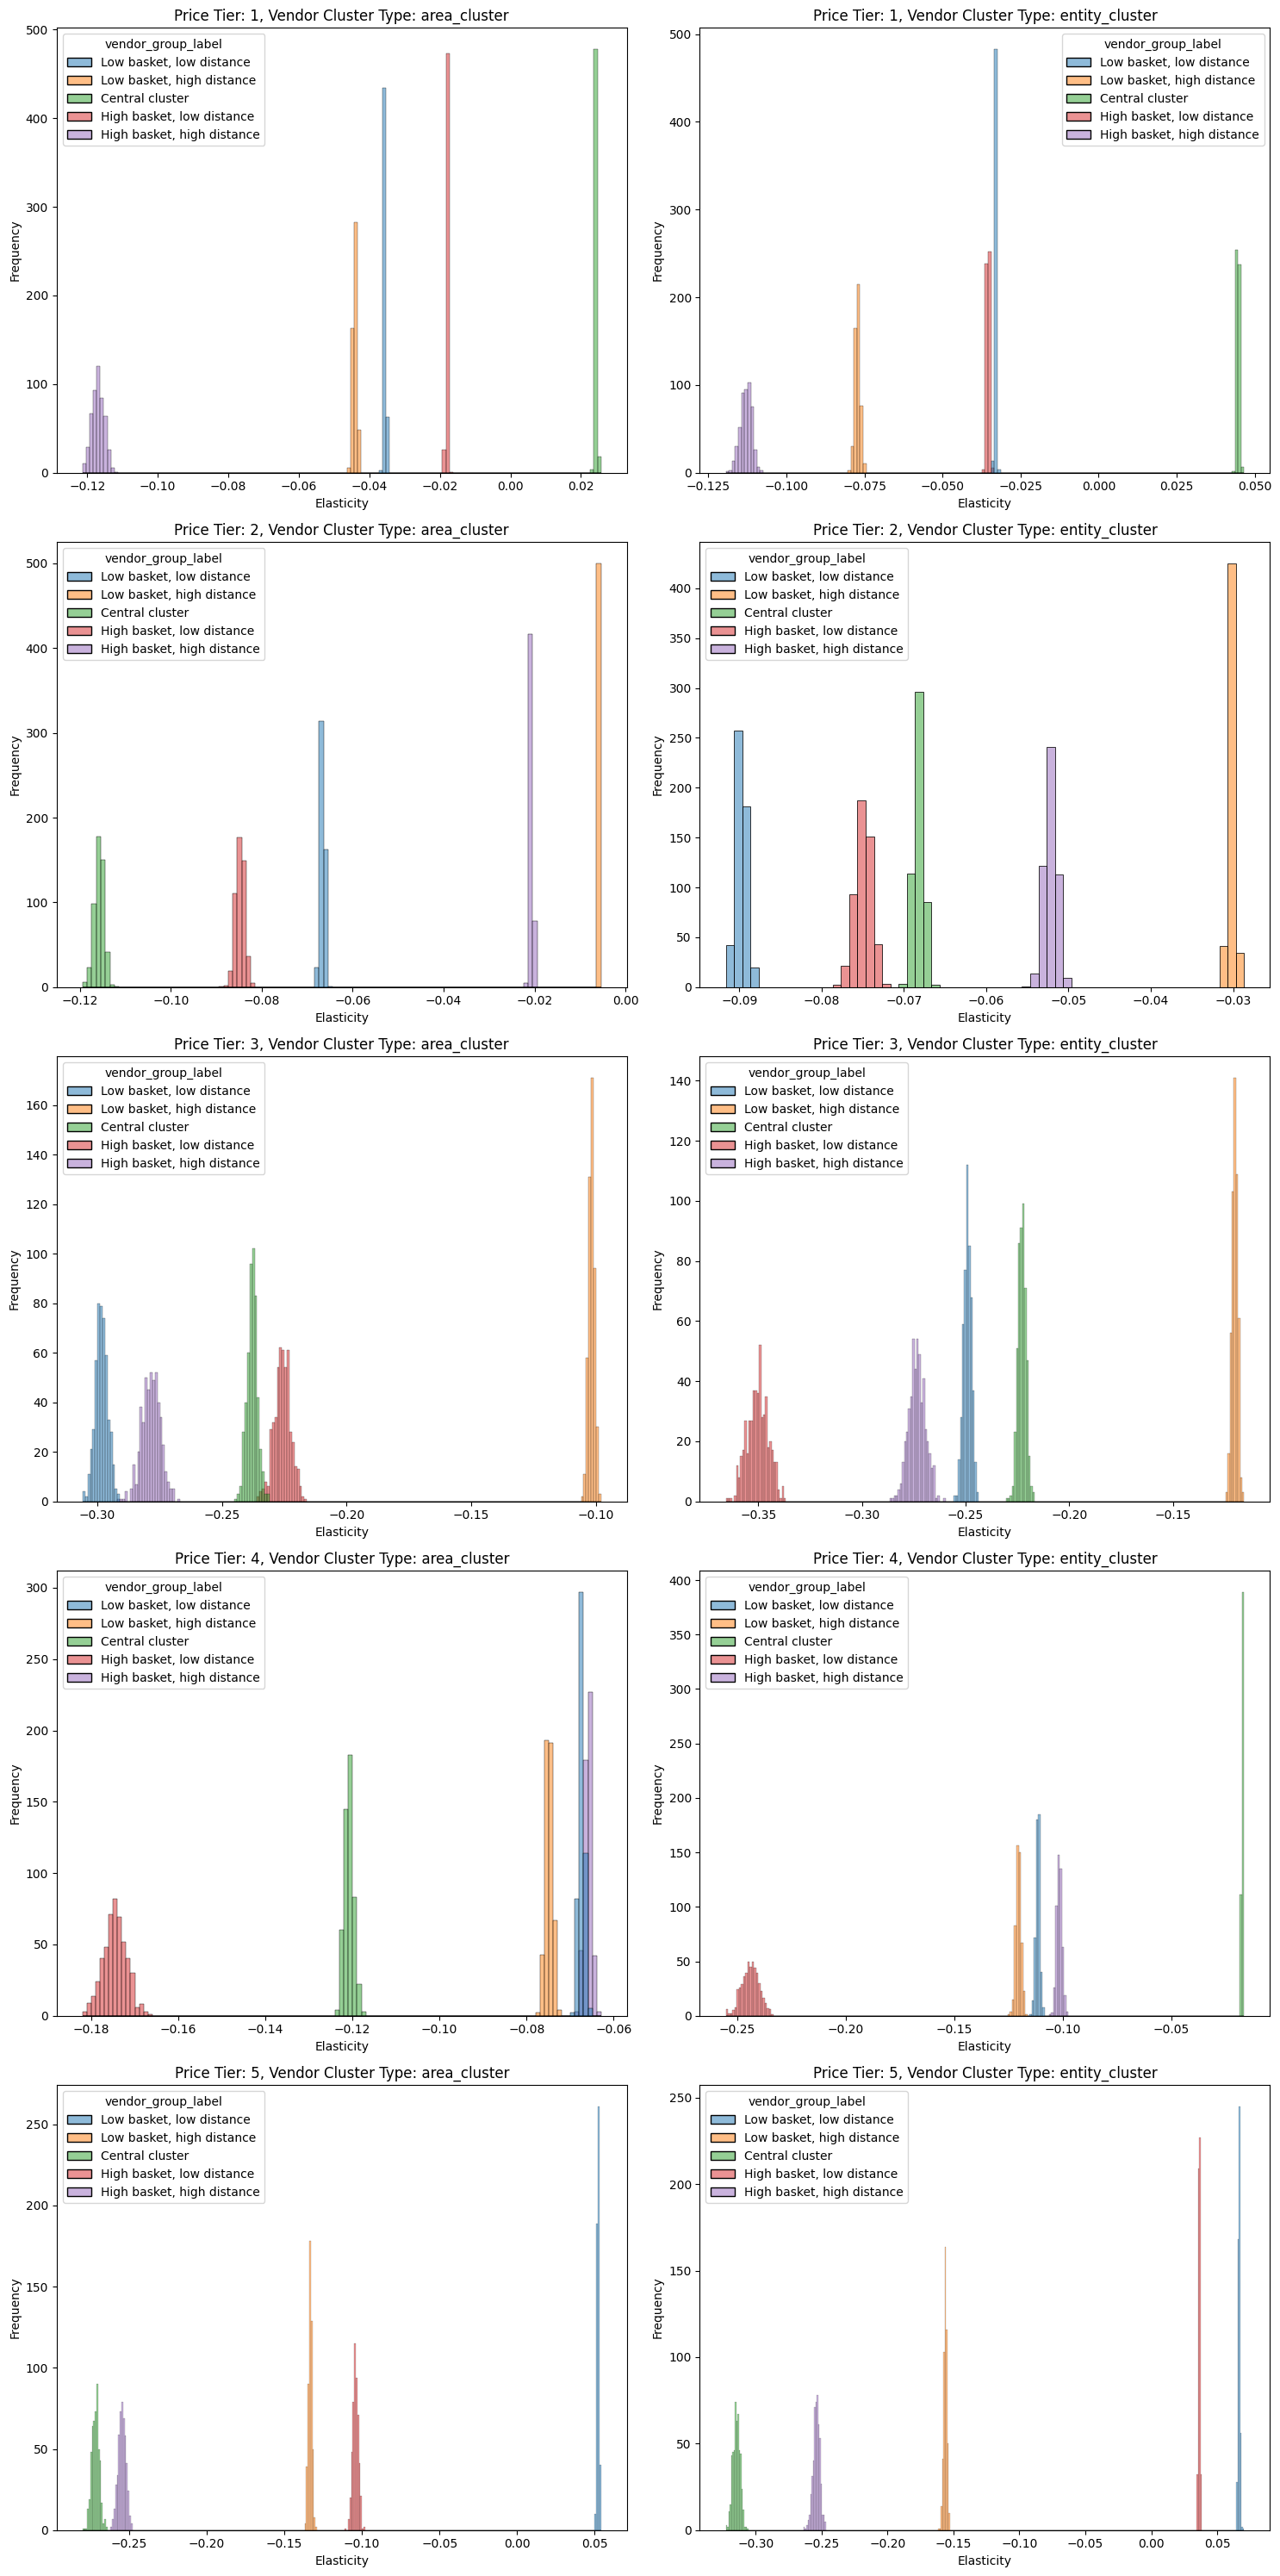

In [72]:
def generate_plot(test_name, dataframe, binwidth):
    # Generate a subplot for each price tier
    fig, axs = plt.subplots(nrows=len(dataframe["price_tier"].unique()), ncols=len(dataframe["cluster_type"].unique()), figsize=(15, 6*len(dataframe["price_tier"].unique())))

    # Filter the dataset for one test
    df_test_filtered = dataframe[dataframe["test_name"] == test_name]

    # Define the desired hue order
    desired_hue_order = [vendor_labels[4], vendor_labels[3], vendor_labels[0], vendor_labels[2], vendor_labels[1]] 

    # Iterate over price tier values and create the histograms
    for i, price_tier in enumerate(price_tiers):
        for j, cluster in enumerate(clusters):
            ax = axs[i, j]
            df_iter = df_test_filtered[(df_test_filtered["price_tier"] == price_tier) & (df_test_filtered["cluster_type"] == cluster)]
            sns.histplot(data=df_iter, x="elasticity", hue="vendor_group_label", hue_order=desired_hue_order, ax=ax, binwidth=binwidth)
            ax.set_title(f"Price Tier: {price_tier}, Vendor Cluster Type: {cluster}")
            ax.set_xlabel("Elasticity")
            ax.set_ylabel("Frequency")

    # Adjust the space between the subplots
    plt.tight_layout()

generate_plot(test_name="CL_20221201_R_B0_O_ElasticityCLRestaurants", dataframe=df_sim_results, binwidth=0.001)

### EXECUTE THIS CELL WITH CAUTION BECAUSE IT WILL ADD DATA TO THE BQ TABLE

In [13]:
# Upload the data frame to BigQuery
job_config = bigquery.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND
client.load_table_from_dataframe(
    dataframe=df_sim_results,
    destination="logistics-data-storage-staging.long_term_pricing.vendor_cluster_tier_level_analysis",
    job_config=job_config
).result()

LoadJob<project=logistics-customer-staging, location=US, id=b62c06a2-4547-4a02-8e81-cd40e3a75de0>